Alexander S. Lundervold, October 25th, 2018

> **UNDER CONSTRUCTION**

# Setup

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from pathlib import Path # Very convenient when working with paths in Python (https://docs.python.org/3.6/library/pathlib.html)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

import seaborn as sns # For nicer plots

In [4]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# Introduction

Now we're ready for one of the most powerful classes of machine learning models there is: based on **boosted trees**. With this tool in your belt you're well-equipped to face most machine learning modelling tasks you'll meet in real life.

Like random forests, boosting is based on ensembling decision trees (or in fact, any other model), having each tree in the ensemble try to **correct the errors of the previous trees**. 

One of the main boosting techniques is called **AdaBoost**. Here each additional tree focuses on the examples that were misclassified by the previous trees. That is, the ensemble iteratively learns from its mistakes. 

We will not focus on AdaBoost here, but rather on a different boosting technique, whose most popular implementation is called `XGBoost`. 

> You should read about AdaBoost in the textbook. 

In **gradient boosting** in general, and XGBoost in particular, each tree added to the ensemble tries to predict the *residual error* from the previously added tree. In other words, it's trained to predict the difference between the correct value and the value predicted from the ensemble so far. 

Each individual tree is what's called a *weak learner*, not able to fit the data very well. But by combining them by having each tree try to predict the residual of the previous trees' predictions, the result is a very *strong learner*. In fact, we can end up with some of the strongest learnes we know. 

## Boosting

We'll try to build a boosting ensemble ourselves. First we'll explain it in a spreadsheet, then in code. Gradient boosting builds on this, as we shall see.

### Boosting spreadsheet

> Go to http://bit.ly/boosting_example for the spreadsheet. We'll go through it in the lecture.

### Boosting using scikit-learn

Let's use the randomly generated data as in the textbook (see Chapter 7).

In [5]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

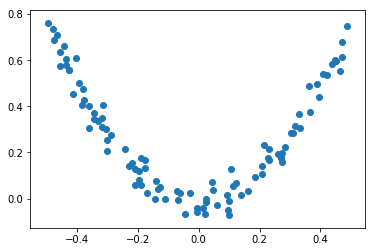

In [6]:
plt.scatter(X,y)
plt.show()

We'll start by training a single decision tree:

In [7]:
from sklearn.tree import DecisionTreeRegressor
tree_1 = DecisionTreeRegressor(max_depth=2)
tree_1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

We need some data on which to predict:

In [8]:
X_new = np.linspace(-0.5, 0.5, 500)
X_new = X_new.reshape(-1, 1)

In [9]:
y_pred_1 = tree_1.predict(X_new)  

*I made a small utility function to plot predictions on top of the data. Simplified from the book's version. See `utils.py` for details*

In [10]:
def plot_predictions(y_pred, axis=None):
    if not axis: 
        fig, ax = plt.subplots()
    ax.plot(X[:, 0], y, 'b.')
    ax.plot(X_new, y_pred, 'g-')
    plt.show()
    return ax

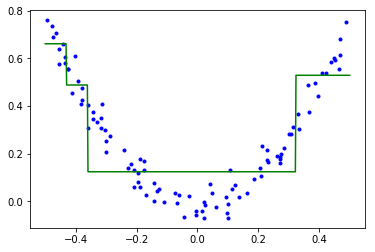

In [11]:
plot_predictions(y_pred_1)

This result is what we want to improve.

Here's the trick: we calculate the residuals and fit another tree to them. Then we make predictions by summing the previous predictions and the predicted residuals. 

Let's make an ensemle containing 3 trees:

In [12]:
y2 = y - tree_1.predict(X)

In [13]:
tree_2 = DecisionTreeRegressor(max_depth=2)

In [14]:
tree_2.fit(X,y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [15]:
y3 = y2 - tree_2.predict(X)

In [16]:
tree_3 = DecisionTreeRegressor(max_depth=2)

In [17]:
tree_3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

...and plot the improvements:

Here was the original result:

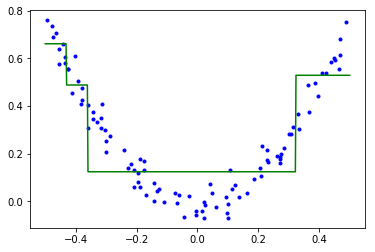

In [18]:
plot_predictions(y_pred_1)

In [19]:
combined_1 = sum([tree.predict(X_new) for tree in [tree_1, tree_2]])

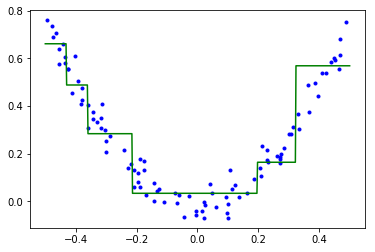

In [20]:
plot_predictions(combined_1)

In [21]:
combined_2 = sum([tree.predict(X_new) for tree in [tree_1, tree_2, tree_3]])

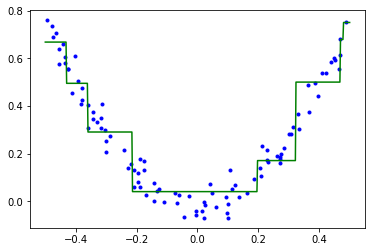

In [22]:
plot_predictions(combined_2)

**Magic!**

We can continue this for as long as we want:

In [23]:
def tree_boosting(k=3):
    """
    Trains k trees on the randomly generated points
    """
    
    # Data
    X = np.random.rand(100, 1) - 0.5
    y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
    
    # Construct trees
    trees = []
    for i in range(k):
        tree = DecisionTreeRegressor(max_depth=2)
        tree.fit(X,y)
        trees.append(tree)
        y = y - tree.predict(X)
    
    # Combine the predictions and plot
    combined = sum([tree.predict(X_new) for tree in trees]) 
    plot_predictions(combined)

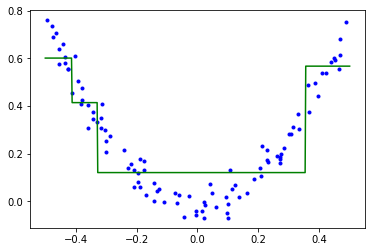

In [24]:
tree_boosting(k=1)

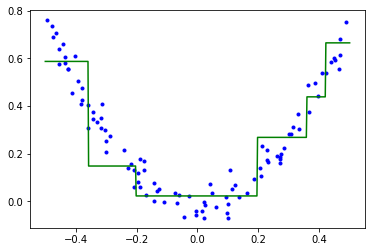

In [25]:
tree_boosting(k=2)

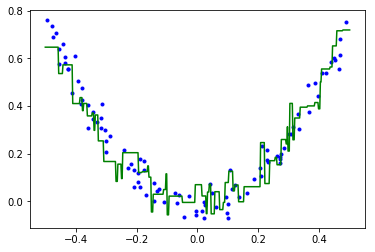

In [26]:
tree_boosting(k=30)

# XGBoost

Scikit-learns's `GradientBoostingClassifier` and `GradientBoostingRegressor` can be used. However, a more widely used implementation of gradient boosting is **XGBoost**: https://xgboost.readthedocs.io/en/latest (other common gradient boosters include LightGBM and CatBoost. Feel free to read about those here https://lightgbm.readthedocs.io/en/latest/index.html and here https://github.com/catboost/catboost) 

We'll focus on XGBoost. 

We won't go into all the details about how XGBoost works. After you've gotten a basic idea of what XGBoost is, and played around with XGBoost on a few examples, you should consider reading  more about the method here:
- http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting
- https://xgboost.readthedocs.io/en/latest/tutorials/model.html
- https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost
- https://campus.datacamp.com/courses/extreme-gradient-boosting-with-xgboost/classification-with-xgboost?ex=1

# MUCH MORE CONTENT TO BE ADDED

# Extra

> Go back to the beginning of the course and use XGBoost on all the data sets we've studied, including the housing data from Assignment 1. You'll see that after some hyperparameter tuning, XGBoost will typically outperform all other models we've studied. This is typical. XGBoost is often the best, **except for images** where deep neural networks outperforms them handily. 

We'll study deep neural networks next, in Part 5 of the course.